# Generating longer signal with pre-trained models

In this notebook, we analyzed the ability of pretained generators to generate longer signals that what they have been trained with. 

##### Import librairies and Declare variables

In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.autograd import Variable
from torch.autograd import grad as torch_grad

import os
import numpy as np
import pandas as pd
import statsmodels.api as sm

from plot_result import Analysis_sf, Analysis_m
from fbm import fbm
from mrw import mrw

from models_conv import Generator, Discriminator
from training import Trainer

from scipy.io import savemat

import seaborn as sns
sns.set(style="darkgrid")

In [2]:
latent_dim = 2**12
ts_dim = 2**12
device = 'cuda' if torch.cuda.is_available() else 'cpu'
epochs = 10000
n = 20
batch_size = 128

##### Import the pretrained models

In [3]:
generators32 = []

for i in range (1,7):
    generator = Generator()
    generator.load_state_dict(torch.load( r'C:\Users\Stage\Desktop\mrw_0.8_0.03\Training n° {}\10000\generator10000 epochs.pth'.format(i)))
    generators32.append(generator)

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter

# Final Activation funtion for the Generator 

class Funct(nn.Module):
    
    def __init__(self, alpha = None, beta = None, initialisation = 0.5):
        super(Funct,self).__init__()
        
        self.tanh = nn.Tanh()
        
        if alpha == None :
            self.alpha = Parameter(torch.tensor(initialisation))
        else :
            self.alpha = Parameter(torch.tensor(alpha))
        self.alpha.requiresGrad = True
        
        if beta == None :
            self.beta = Parameter(torch.tensor(initialisation))
        else :
            self.beta = Parameter(torch.tensor(alpha))
        self.beta.requiresGrad = True
        
    def forward(self,x): 
        return self.beta* self.tanh(self.alpha * x)
    
    
# Generator

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.Layer0 = nn.Conv1d(1, 1, kernel_size = 512, padding = 'same')
        self.batch0 = nn.BatchNorm1d(1)
        
        self.conv1 = nn.ConvTranspose1d(8, 4, kernel_size = 7, stride = 2, output_padding = 1, padding = 3)
        self.batch1 = nn.BatchNorm1d(4)
        
        self.conv2 = nn.ConvTranspose1d(4, 2, kernel_size = 7, stride = 2, output_padding = 1, padding = 3)
        self.batch2 = nn.BatchNorm1d(2)
        
        self.conv3 = nn.ConvTranspose1d(2, 1, kernel_size = 7, stride = 2, output_padding = 1, padding = 3)
        self.batch3 = nn.BatchNorm1d(1)
        
        #final activation function 
        self.f = Funct()


    
    def forward(self, x):
        x = x.view(x.shape[0], 1, x.shape[1])
        
        x = self.Layer0(x)
        x = self.batch0(x)
        x = F.leaky_relu(x, 0.2)
        
        #Reshaping
        x = x.view(x.shape[0], 8, x.shape[2]//8)
        
        x = self.batch1(self.conv1(x))
        x = F.leaky_relu(x, 0.2)
        
        x = self.batch2(self.conv2(x))
        x = F.leaky_relu(x, 0.2)
        
        x = self.batch3(self.conv3(x))
        
        x = x.squeeze()
        
        return self.f(x)

In [6]:
generators512 =[]
for i in range (1,7):
    generator = Generator()
    generator.load_state_dict(torch.load( r'C:\Users\Stage\Desktop\WGAN_times_series\Synthetization of a fbm\output\2022-07-21_mrw_0.8_0.03_conv\512\Training n° {}\10000\generator10000 epochs.pth'.format(i)))
    generators512.append(generator)

In [4]:
def create_real_data(latent_dim, dim, H, device, L):
    data = []
    ecart = []
    for _ in range (dim):
        x = mrw(latent_dim+1, H, np.sqrt(0.03), L)
        x = np.diff(x)
                
        data.append(x)
        ecart.append(np.array(x).std())
            
    ecart = np.array(ecart)
    sigma = ecart.mean()
    data = np.array(data) / sigma * 0.1
    data = data.astype('float32')
        
    data = torch.tensor(data)
        
    return data.to(device)

In [5]:
def plot_save(generator, analyse12, analyse13, analyse14, analyse15, analyse16, analyse17, conv, c):
    
    plt.figure(1, figsize = (6.1*2, 4*2))
    plt.plot(analyse12[0].j, np.array([analyse12[i].wavelet_result_synthetic[0] for i in range (6)]).mean(axis = 0), 'r')
    plt.errorbar(analyse12[0].j,\
             np.array([analyse12[i].wavelet_result_synthetic[0] for i in range (6)]).mean(axis = 0),\
             yerr = np.array([analyse12[i].wavelet_result_synthetic[0] for i in range (6)]).std(axis = 0),\
             fmt = 'none', capsize = 10, ecolor = 'r', elinewidth = 1, capthick = 2)

    plt.figure(1, figsize = (6.1*2, 4*2))
    plt.plot(analyse13[0].j, np.array([analyse13[i].wavelet_result_synthetic[0] for i in range (6)]).mean(axis = 0), 'r')
    plt.errorbar(analyse13[0].j,\
             np.array([analyse13[i].wavelet_result_synthetic[0] for i in range (6)]).mean(axis = 0),\
             yerr = np.array([analyse13[i].wavelet_result_synthetic[0] for i in range (6)]).std(axis = 0),\
             fmt = 'none', capsize = 10, ecolor = 'r', elinewidth = 1, capthick = 2)

    plt.plot(analyse14[0].j, np.array([analyse14[i].wavelet_result_synthetic[0] for i in range (6)]).mean(axis = 0), 'r')
    plt.errorbar(analyse14[0].j,\
             np.array([analyse14[i].wavelet_result_synthetic[0] for i in range (6)]).mean(axis = 0),\
             yerr = np.array([analyse14[i].wavelet_result_synthetic[0] for i in range (6)]).std(axis = 0),\
             fmt = 'none', capsize = 10, ecolor = 'r', elinewidth = 1, capthick = 2)

    plt.plot(analyse15[0].j, np.array([analyse15[i].wavelet_result_synthetic[0] for i in range (6)]).mean(axis = 0), 'r')
    plt.errorbar(analyse15[0].j,\
             np.array([analyse15[i].wavelet_result_synthetic[0] for i in range (6)]).mean(axis = 0),\
             yerr = np.array([analyse15[i].wavelet_result_synthetic[0] for i in range (6)]).std(axis = 0),\
             fmt = 'none', capsize = 10, ecolor = 'r', elinewidth = 1, capthick = 2)

    plt.plot(analyse16[0].j, np.array([analyse16[i].wavelet_result_synthetic[0] for i in range (6)]).mean(axis = 0), 'r')
    plt.errorbar(analyse16[0].j,\
             np.array([analyse16[i].wavelet_result_synthetic[0] for i in range (6)]).mean(axis = 0),\
             yerr = np.array([analyse16[i].wavelet_result_synthetic[0] for i in range (6)]).std(axis = 0),\
             fmt = 'none', capsize = 10, ecolor = 'r', elinewidth = 1, capthick = 2)

    plt.plot(analyse17[0].j, np.array([analyse17[i].wavelet_result_synthetic[0] for i in range (6)]).mean(axis = 0), 'r')
    plt.errorbar(analyse17[0].j,\
             np.array([analyse17[i].wavelet_result_synthetic[0] for i in range (6)]).mean(axis = 0),\
             yerr = np.array([analyse17[i].wavelet_result_synthetic[0] for i in range (6)]).std(axis = 0),\
             fmt = 'none', capsize = 10, ecolor = 'r', elinewidth = 1, capthick = 2)


    plt.plot(analyse12[0].j, analyse12[0].wavelet_result_data[0], c= 'k')
    plt.scatter(analyse12[0].j, analyse12[0].wavelet_result_data[0], c = 'k',s=20)

    plt.plot(analyse13[0].j, analyse13[0].wavelet_result_data[0], c= 'k')
    plt.scatter(analyse13[0].j, analyse13[0].wavelet_result_data[0], c = 'k',s=20)

    plt.plot(analyse14[0].j, analyse14[0].wavelet_result_data[0], c= 'k')
    plt.scatter(analyse14[0].j, analyse14[0].wavelet_result_data[0], c = 'k',s=20)

    plt.plot(analyse15[0].j, analyse15[0].wavelet_result_data[0], c= 'k')
    plt.scatter(analyse15[0].j, analyse15[0].wavelet_result_data[0], c = 'k',s=20)

    plt.plot(analyse16[0].j, analyse16[0].wavelet_result_data[0], c= 'k')
    plt.scatter(analyse16[0].j, analyse16[0].wavelet_result_data[0], c = 'k',s=20)

    plt.plot(analyse17[0].j, analyse17[0].wavelet_result_data[0], c= 'k')
    plt.scatter(analyse17[0].j, analyse17[0].wavelet_result_data[0], c = 'k',s=20)

    plt.show()
    
    
    
    plt.figure(1, figsize = (6.1*2, 4*2))
    plt.plot(analyse12[0].j, np.array([analyse12[i].cumul_result2_synthetic[0] for i in range (6)]).mean(axis = 0), 'r')
    plt.errorbar(analyse12[0].j,\
             np.array([analyse12[i].cumul_result2_synthetic[0] for i in range (6)]).mean(axis = 0),\
             yerr = np.array([analyse12[i].cumul_result2_synthetic[0] for i in range (6)]).std(axis = 0),\
             fmt = 'none', capsize = 10, ecolor = 'r', elinewidth = 1, capthick = 2)

    plt.figure(1, figsize = (6.1*2, 4*2))
    plt.plot(analyse13[0].j, np.array([analyse13[i].cumul_result2_synthetic[0] for i in range (6)]).mean(axis = 0), 'r')
    plt.errorbar(analyse13[0].j,\
             np.array([analyse13[i].cumul_result2_synthetic[0] for i in range (6)]).mean(axis = 0),\
             yerr = np.array([analyse13[i].cumul_result2_synthetic[0] for i in range (6)]).std(axis = 0),\
             fmt = 'none', capsize = 10, ecolor = 'r', elinewidth = 1, capthick = 2)

    plt.plot(analyse14[0].j, np.array([analyse14[i].cumul_result2_synthetic[0] for i in range (6)]).mean(axis = 0), 'r')
    plt.errorbar(analyse14[0].j,\
             np.array([analyse14[i].cumul_result2_synthetic[0] for i in range (6)]).mean(axis = 0),\
             yerr = np.array([analyse14[i].cumul_result2_synthetic[0] for i in range (6)]).std(axis = 0),\
             fmt = 'none', capsize = 10, ecolor = 'r', elinewidth = 1, capthick = 2)

    plt.plot(analyse15[0].j, np.array([analyse15[i].cumul_result2_synthetic[0] for i in range (6)]).mean(axis = 0), 'r')
    plt.errorbar(analyse15[0].j,\
             np.array([analyse15[i].cumul_result2_synthetic[0] for i in range (6)]).mean(axis = 0),\
             yerr = np.array([analyse15[i].cumul_result2_synthetic[0] for i in range (6)]).std(axis = 0),\
             fmt = 'none', capsize = 10, ecolor = 'r', elinewidth = 1, capthick = 2)

    plt.plot(analyse16[0].j, np.array([analyse16[i].cumul_result2_synthetic[0] for i in range (6)]).mean(axis = 0), 'r')
    plt.errorbar(analyse16[0].j,\
             np.array([analyse16[i].cumul_result2_synthetic[0] for i in range (6)]).mean(axis = 0),\
             yerr = np.array([analyse16[i].cumul_result2_synthetic[0] for i in range (6)]).std(axis = 0),\
             fmt = 'none', capsize = 10, ecolor = 'r', elinewidth = 1, capthick = 2)

    plt.plot(analyse17[0].j, np.array([analyse17[i].cumul_result2_synthetic[0] for i in range (6)]).mean(axis = 0), 'r')
    plt.errorbar(analyse17[0].j,\
             np.array([analyse17[i].cumul_result2_synthetic[0] for i in range (6)]).mean(axis = 0),\
             yerr = np.array([analyse17[i].cumul_result2_synthetic[0] for i in range (6)]).std(axis = 0),\
             fmt = 'none', capsize = 10, ecolor = 'r', elinewidth = 1, capthick = 2)


    plt.plot(analyse12[0].j, analyse12[0].cumul_result2_data[0], c= 'k')
    plt.scatter(analyse12[0].j, analyse12[0].cumul_result2_data[0], c = 'k',s=20)

    plt.plot(analyse13[0].j, analyse13[0].cumul_result2_data[0], c= 'k')
    plt.scatter(analyse13[0].j, analyse13[0].cumul_result2_data[0], c = 'k',s=20)

    plt.plot(analyse14[0].j, analyse14[0].cumul_result2_data[0], c= 'k')
    plt.scatter(analyse14[0].j, analyse14[0].cumul_result2_data[0], c = 'k',s=20)

    plt.plot(analyse15[0].j, analyse15[0].cumul_result2_data[0], c= 'k')
    plt.scatter(analyse15[0].j, analyse15[0].cumul_result2_data[0], c = 'k',s=20)

    plt.plot(analyse16[0].j, analyse16[0].cumul_result2_data[0], c= 'k')
    plt.scatter(analyse16[0].j, analyse16[0].cumul_result2_data[0], c = 'k',s=20)

    plt.plot(analyse17[0].j, analyse17[0].cumul_result2_data[0], c= 'k')
    plt.scatter(analyse17[0].j, analyse17[0].cumul_result2_data[0], c = 'k',s=20)

    plt.show()
    
    
    
    
    sf_ = { 'TS_12' : analyse12[0].wavelet_result_data, 
          'TS_13' : analyse13[0].wavelet_result_data, 
          'TS_14' : analyse14[0].wavelet_result_data,     
          'TS_15' : analyse15[0].wavelet_result_data, 
          'TS_16' : analyse16[0].wavelet_result_data,
             'TS_17' : analyse17[0].wavelet_result_data
         }

    for i in range (len(generator)):
        sf_['TConv{}_12_{}'.format(conv, i+1)] = analyse12[i].wavelet_result_synthetic
        sf_['TConv{}_13_{}'.format(conv, i+1)] = analyse13[i].wavelet_result_synthetic
        sf_['TConv{}_14_{}'.format(conv, i+1)] = analyse14[i].wavelet_result_synthetic
        sf_['TConv{}_15_{}'.format(conv, i+1)] = analyse15[i].wavelet_result_synthetic
        sf_['TConv{}_16_{}'.format(conv, i+1)] = analyse16[i].wavelet_result_synthetic
        sf_['TConv{}_17_{}'.format(conv, i+1)] = analyse17[i].wavelet_result_synthetic

    savemat(r'C:\Users\Stage\Desktop\dataFigure\Matlab\dataFigureSF'+c+'.mat', sf_)
    np.save(r'C:\Users\Stage\Desktop\dataFigure\Python\dataFigureSF'+c, sf_)
    
    C2_ = { 'TS_12' : analyse12[0].cumul_result2_data, 
          'TS_13' : analyse13[0].cumul_result2_data, 
          'TS_14' : analyse14[0].cumul_result2_data,     
          'TS_15' : analyse15[0].cumul_result2_data, 
          'TS_16' : analyse16[0].cumul_result2_data,
             'TS_17' : analyse17[0].cumul_result2_data
         }

    for i in range (len(generator)):
        C2_['TConv{}_12_{}'.format(conv, i+1)] = analyse12[i].cumul_result2_synthetic
        C2_['TConv{}_13_{}'.format(conv, i+1)] = analyse13[i].cumul_result2_synthetic
        C2_['TConv{}_14_{}'.format(conv, i+1)] = analyse14[i].cumul_result2_synthetic
        C2_['TConv{}_15_{}'.format(conv, i+1)] = analyse15[i].cumul_result2_synthetic
        C2_['TConv{}_16_{}'.format(conv, i+1)] = analyse16[i].cumul_result2_synthetic
        C2_['TConv{}_17_{}'.format(conv, i+1)] = analyse17[i].cumul_result2_synthetic

    savemat(r'C:\Users\Stage\Desktop\dataFigure\Matlab\dataFigureC2'+c+'.mat', C2_)
    np.save(r'C:\Users\Stage\Desktop\dataFigure\Python\dataFigureC2'+c, C2_)


    sf_mean = { 'TS_12' : analyse12[0].wavelet_result_data, 
                  'T512_12' : np.array([analyse12[i].wavelet_result_synthetic[0] for i in range (6)]).mean(axis = 0),
                  'T512_12_std' :np.array([analyse12[i].wavelet_result_synthetic[0] for i in range (6)]).std(axis = 0),
              
                  'TS_13' : analyse13[0].wavelet_result_data, 
                  'T512_13' : np.array([analyse13[i].wavelet_result_synthetic[0] for i in range (6)]).mean(axis = 0),
                  'T512_13_std' :np.array([analyse13[i].wavelet_result_synthetic[0] for i in range (6)]).std(axis = 0),
             
                  'TS_14' : analyse14[0].wavelet_result_data, 
                  'T512_14' : np.array([analyse14[i].wavelet_result_synthetic[0] for i in range (6)]).mean(axis = 0),
                  'T512_14_std' :np.array([analyse14[i].wavelet_result_synthetic[0] for i in range (6)]).std(axis = 0),
                 
                  'TS_15' : analyse15[0].wavelet_result_data, 
                  'T512_15' : np.array([analyse15[i].wavelet_result_synthetic[0] for i in range (6)]).mean(axis = 0),
                  'T512_15_std' :np.array([analyse15[i].wavelet_result_synthetic[0] for i in range (6)]).std(axis = 0),
                 
                  'TS_16' : analyse16[0].wavelet_result_data, 
                  'T512_16' : np.array([analyse16[i].wavelet_result_synthetic[0] for i in range (6)]).mean(axis = 0),
                  'T512_16_std' :np.array([analyse16[i].wavelet_result_synthetic[0] for i in range (6)]).std(axis = 0),
                 
                 'TS_17' : analyse17[0].wavelet_result_data, 
                 'T512_17' : np.array([analyse17[i].wavelet_result_synthetic[0] for i in range (6)]).mean(axis = 0),
                 'T512_17_std' :np.array([analyse17[i].wavelet_result_synthetic[0] for i in range (6)]).std(axis = 0)  
             }

    savemat(r'C:\Users\Stage\Desktop\dataFigure\Matlab\dataFigureSF'+c+'mean.mat', sf_mean)
    np.save(r'C:\Users\Stage\Desktop\dataFigure\Python\dataFigureSF'+c+'mean', sf_mean)
    
    c2_mean = { 'TS_12' : analyse12[0].cumul_result2_data, 
                  'T512_12' : np.array([analyse12[i].cumul_result2_synthetic[0] for i in range (6)]).mean(axis = 0),
                  'T512_12_std' :np.array([analyse12[i].cumul_result2_synthetic[0] for i in range (6)]).std(axis = 0),
              
                  'TS_13' : analyse13[0].cumul_result2_data, 
                  'T512_13' : np.array([analyse13[i].cumul_result2_synthetic[0] for i in range (6)]).mean(axis = 0),
                  'T512_13_std' :np.array([analyse13[i].cumul_result2_synthetic[0] for i in range (6)]).std(axis = 0),
             
                  'TS_14' : analyse14[0].cumul_result2_data, 
                  'T512_14' : np.array([analyse14[i].cumul_result2_synthetic[0] for i in range (6)]).mean(axis = 0),
                  'T512_14_std' :np.array([analyse14[i].cumul_result2_synthetic[0] for i in range (6)]).std(axis = 0),
                 
                  'TS_15' : analyse15[0].cumul_result2_data, 
                  'T512_15' : np.array([analyse15[i].cumul_result2_synthetic[0] for i in range (6)]).mean(axis = 0),
                  'T512_15_std' :np.array([analyse15[i].cumul_result2_synthetic[0] for i in range (6)]).std(axis = 0),
                 
                  'TS_16' : analyse16[0].cumul_result2_data, 
                  'T512_16' : np.array([analyse16[i].cumul_result2_synthetic[0] for i in range (6)]).mean(axis = 0),
                  'T512_16_std' :np.array([analyse16[i].cumul_result2_synthetic[0] for i in range (6)]).std(axis = 0),
                 
                 'TS_17' : analyse17[0].cumul_result2_data, 
                 'T512_17' : np.array([analyse17[i].cumul_result2_synthetic[0] for i in range (6)]).mean(axis = 0),
                 'T512_17_std' :np.array([analyse17[i].cumul_result2_synthetic[0] for i in range (6)]).std(axis = 0)  
             }

    savemat(r'C:\Users\Stage\Desktop\dataFigure\Matlab\dataFigureC2'+c+'mean.mat', c2_mean)
    np.save(r'C:\Users\Stage\Desktop\dataFigure\Python\dataFigureC2'+c+'mean', c2_mean)

In [6]:
true_data_12 = create_real_data(2**12, 1000, 0.8, 'cpu', 2**12)
true_data_13 = create_real_data(2**13, 1000, 0.8, 'cpu', 2**12)
true_data_14 = create_real_data(2**14, 1000, 0.8, 'cpu', 2**12)
true_data_15 = create_real_data(2**15, 1000, 0.8, 'cpu', 2**12)
true_data_16 = create_real_data(2**16, 1000, 0.8, 'cpu', 2**12)
true_data_17 = create_real_data(2**17, 1000, 0.8, 'cpu', 2**12)

In [6]:
true_data_12L = create_real_data(2**12, 1000, 0.8, 'cpu', 2**12)
true_data_13L = create_real_data(2**13, 1000, 0.8, 'cpu', 2**13)
true_data_14L = create_real_data(2**14, 1000, 0.8, 'cpu', 2**14)
true_data_15L = create_real_data(2**15, 1000, 0.8, 'cpu', 2**15)
true_data_16L = create_real_data(2**16, 1000, 0.8, 'cpu', 2**16)
true_data_17L = create_real_data(2**17, 1000, 0.8, 'cpu', 2**17)

#### MRW Conv512

##### MRW Conv512 Larger N L12

In [9]:
analyse512_12 = []
analyse512_13 = []
analyse512_14 = []
analyse512_15 = []
analyse512_16 = []
analyse512_17 = []

for i in range (len(generators512)):
    
    noise = torch.normal(mean = 0, std = 0.3, size =(1000, 2**12))
    synthetic_data_12 = generators512[i](noise)
    analysis12 = Analysis_sf(true_data_12, synthetic_data_12, r'C:\Users\Stage\Desktop\mrw_0.8_0.03')
    analyse512_12.append(analysis12)
    
    noise = torch.normal(mean = 0, std = 0.3, size =(1000, 2**13))
    synthetic_data_13 = generators512[i](noise)
    analysis13 = Analysis_sf(true_data_13, synthetic_data_13, r'C:\Users\Stage\Desktop\mrw_0.8_0.03')
    analyse512_13.append(analysis13)

    noise = torch.normal(mean = 0, std = 0.3, size =(1000, 2**14))
    synthetic_data_14 = generators512[i](noise)
    analysis14 = Analysis_sf(true_data_14, synthetic_data_14, r'C:\Users\Stage\Desktop\mrw_0.8_0.03')
    analyse512_14.append(analysis14)
    
    noise = torch.normal(mean = 0, std = 0.3, size =(1000, 2**15))
    synthetic_data_15 = generators512[i](noise)
    analysis15 = Analysis_sf(true_data_15, synthetic_data_15, r'C:\Users\Stage\Desktop\mrw_0.8_0.03')
    analyse512_15.append(analysis15)

    noise = torch.normal(mean = 0, std = 0.3, size =(1000, 2**16))
    synthetic_data_16 = generators512[i](noise)
    analysis16 = Analysis_sf(true_data_16, synthetic_data_16, r'C:\Users\Stage\Desktop\mrw_0.8_0.03')
    analyse512_16.append(analysis16)
    
    noise = torch.normal(mean = 0, std = 0.3, size =(1000, 2**17))
    synthetic_data_17 = generators512[i](noise)
    analysis17 = Analysis_sf(true_data_17, synthetic_data_17, r'C:\Users\Stage\Desktop\mrw_0.8_0.03')
    analyse512_17.append(analysis17)

C:\Users\Stage\anaconda3\lib\site-packages\torch\nn\modules\conv.py:298: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\Convolution.cpp:744.)
  return F.conv1d(input, weight, bias, self.stride,


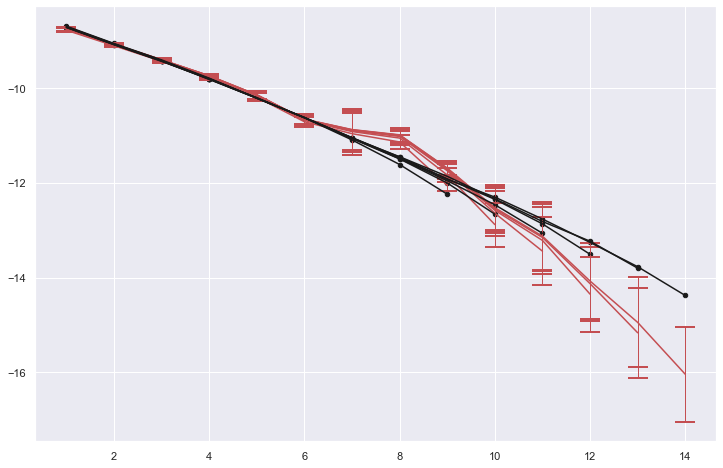

In [10]:
plt.figure(1, figsize = (6.1*2, 4*2))
plt.plot(analyse512_12[0].j, np.array([analyse512_12[i].wavelet_result_synthetic[0] for i in range (6)]).mean(axis = 0), 'r')
plt.errorbar(analyse512_12[0].j,\
             np.array([analyse512_12[i].wavelet_result_synthetic[0] for i in range (6)]).mean(axis = 0),\
             yerr = np.array([analyse512_12[i].wavelet_result_synthetic[0] for i in range (6)]).std(axis = 0),\
             fmt = 'none', capsize = 10, ecolor = 'r', elinewidth = 1, capthick = 2)

plt.figure(1, figsize = (6.1*2, 4*2))
plt.plot(analyse512_13[0].j, np.array([analyse512_13[i].wavelet_result_synthetic[0] for i in range (6)]).mean(axis = 0), 'r')
plt.errorbar(analyse512_13[0].j,\
             np.array([analyse512_13[i].wavelet_result_synthetic[0] for i in range (6)]).mean(axis = 0),\
             yerr = np.array([analyse512_13[i].wavelet_result_synthetic[0] for i in range (6)]).std(axis = 0),\
             fmt = 'none', capsize = 10, ecolor = 'r', elinewidth = 1, capthick = 2)

plt.plot(analyse512_14[0].j, np.array([analyse512_14[i].wavelet_result_synthetic[0] for i in range (6)]).mean(axis = 0), 'r')
plt.errorbar(analyse512_14[0].j,\
             np.array([analyse512_14[i].wavelet_result_synthetic[0] for i in range (6)]).mean(axis = 0),\
             yerr = np.array([analyse512_14[i].wavelet_result_synthetic[0] for i in range (6)]).std(axis = 0),\
             fmt = 'none', capsize = 10, ecolor = 'r', elinewidth = 1, capthick = 2)

plt.plot(analyse512_15[0].j, np.array([analyse512_15[i].wavelet_result_synthetic[0] for i in range (6)]).mean(axis = 0), 'r')
plt.errorbar(analyse512_15[0].j,\
             np.array([analyse512_15[i].wavelet_result_synthetic[0] for i in range (6)]).mean(axis = 0),\
             yerr = np.array([analyse512_15[i].wavelet_result_synthetic[0] for i in range (6)]).std(axis = 0),\
             fmt = 'none', capsize = 10, ecolor = 'r', elinewidth = 1, capthick = 2)

plt.plot(analyse512_16[0].j, np.array([analyse512_16[i].wavelet_result_synthetic[0] for i in range (6)]).mean(axis = 0), 'r')
plt.errorbar(analyse512_16[0].j,\
             np.array([analyse512_16[i].wavelet_result_synthetic[0] for i in range (6)]).mean(axis = 0),\
             yerr = np.array([analyse512_16[i].wavelet_result_synthetic[0] for i in range (6)]).std(axis = 0),\
             fmt = 'none', capsize = 10, ecolor = 'r', elinewidth = 1, capthick = 2)

plt.plot(analyse512_17[0].j, np.array([analyse512_17[i].wavelet_result_synthetic[0] for i in range (6)]).mean(axis = 0), 'r')
plt.errorbar(analyse512_17[0].j,\
             np.array([analyse512_17[i].wavelet_result_synthetic[0] for i in range (6)]).mean(axis = 0),\
             yerr = np.array([analyse512_17[i].wavelet_result_synthetic[0] for i in range (6)]).std(axis = 0),\
             fmt = 'none', capsize = 10, ecolor = 'r', elinewidth = 1, capthick = 2)


plt.plot(analyse512_12[0].j, analyse512_12[0].wavelet_result_data[0], c= 'k')
plt.scatter(analyse512_12[0].j, analyse512_12[0].wavelet_result_data[0], c = 'k',s=20)

plt.plot(analyse512_13[0].j, analyse512_13[0].wavelet_result_data[0], c= 'k')
plt.scatter(analyse512_13[0].j, analyse512_13[0].wavelet_result_data[0], c = 'k',s=20)

plt.plot(analyse512_14[0].j, analyse512_14[0].wavelet_result_data[0], c= 'k')
plt.scatter(analyse512_14[0].j, analyse512_14[0].wavelet_result_data[0], c = 'k',s=20)

plt.plot(analyse512_15[0].j, analyse512_15[0].wavelet_result_data[0], c= 'k')
plt.scatter(analyse512_15[0].j, analyse512_15[0].wavelet_result_data[0], c = 'k',s=20)

plt.plot(analyse512_16[0].j, analyse512_16[0].wavelet_result_data[0], c= 'k')
plt.scatter(analyse512_16[0].j, analyse512_16[0].wavelet_result_data[0], c = 'k',s=20)

plt.plot(analyse512_17[0].j, analyse512_17[0].wavelet_result_data[0], c= 'k')
plt.scatter(analyse512_17[0].j, analyse512_17[0].wavelet_result_data[0], c = 'k',s=20)

plt.show()

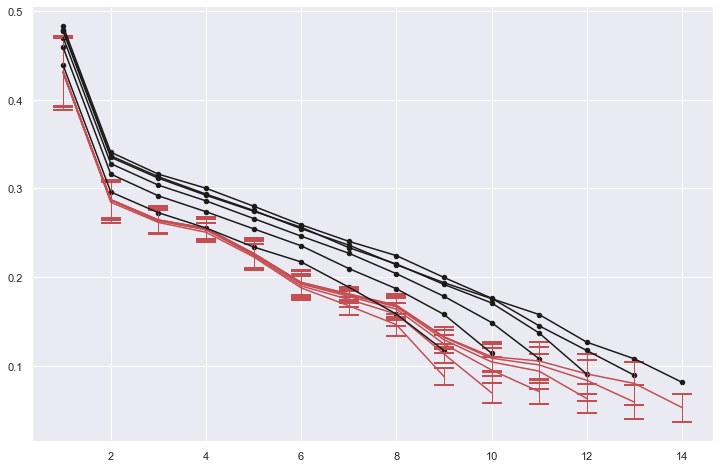

In [11]:
plt.figure(1, figsize = (6.1*2, 4*2))
plt.plot(analyse512_12[0].j, np.array([analyse512_12[i].cumul_result2_synthetic[0] for i in range (6)]).mean(axis = 0), 'r')
plt.errorbar(analyse512_12[0].j,\
             np.array([analyse512_12[i].cumul_result2_synthetic[0] for i in range (6)]).mean(axis = 0),\
             yerr = np.array([analyse512_12[i].cumul_result2_synthetic[0] for i in range (6)]).std(axis = 0),\
             fmt = 'none', capsize = 10, ecolor = 'r', elinewidth = 1, capthick = 2)

plt.figure(1, figsize = (6.1*2, 4*2))
plt.plot(analyse512_13[0].j, np.array([analyse512_13[i].cumul_result2_synthetic[0] for i in range (6)]).mean(axis = 0), 'r')
plt.errorbar(analyse512_13[0].j,\
             np.array([analyse512_13[i].cumul_result2_synthetic[0] for i in range (6)]).mean(axis = 0),\
             yerr = np.array([analyse512_13[i].cumul_result2_synthetic[0] for i in range (6)]).std(axis = 0),\
             fmt = 'none', capsize = 10, ecolor = 'r', elinewidth = 1, capthick = 2)

plt.plot(analyse512_14[0].j, np.array([analyse512_14[i].cumul_result2_synthetic[0] for i in range (6)]).mean(axis = 0), 'r')
plt.errorbar(analyse512_14[0].j,\
             np.array([analyse512_14[i].cumul_result2_synthetic[0] for i in range (6)]).mean(axis = 0),\
             yerr = np.array([analyse512_14[i].cumul_result2_synthetic[0] for i in range (6)]).std(axis = 0),\
             fmt = 'none', capsize = 10, ecolor = 'r', elinewidth = 1, capthick = 2)

plt.plot(analyse512_15[0].j, np.array([analyse512_15[i].cumul_result2_synthetic[0] for i in range (6)]).mean(axis = 0), 'r')
plt.errorbar(analyse512_15[0].j,\
             np.array([analyse512_15[i].cumul_result2_synthetic[0] for i in range (6)]).mean(axis = 0),\
             yerr = np.array([analyse512_15[i].cumul_result2_synthetic[0] for i in range (6)]).std(axis = 0),\
             fmt = 'none', capsize = 10, ecolor = 'r', elinewidth = 1, capthick = 2)

plt.plot(analyse512_16[0].j, np.array([analyse512_16[i].cumul_result2_synthetic[0] for i in range (6)]).mean(axis = 0), 'r')
plt.errorbar(analyse512_16[0].j,\
             np.array([analyse512_16[i].cumul_result2_synthetic[0] for i in range (6)]).mean(axis = 0),\
             yerr = np.array([analyse512_16[i].cumul_result2_synthetic[0] for i in range (6)]).std(axis = 0),\
             fmt = 'none', capsize = 10, ecolor = 'r', elinewidth = 1, capthick = 2)

plt.plot(analyse512_17[0].j, np.array([analyse512_17[i].cumul_result2_synthetic[0] for i in range (6)]).mean(axis = 0), 'r')
plt.errorbar(analyse512_17[0].j,\
             np.array([analyse512_17[i].cumul_result2_synthetic[0] for i in range (6)]).mean(axis = 0),\
             yerr = np.array([analyse512_17[i].cumul_result2_synthetic[0] for i in range (6)]).std(axis = 0),\
             fmt = 'none', capsize = 10, ecolor = 'r', elinewidth = 1, capthick = 2)


plt.plot(analyse512_12[0].j, analyse512_12[0].cumul_result2_data[0], c= 'k')
plt.scatter(analyse512_12[0].j, analyse512_12[0].cumul_result2_data[0], c = 'k',s=20)

plt.plot(analyse512_13[0].j, analyse512_13[0].cumul_result2_data[0], c= 'k')
plt.scatter(analyse512_13[0].j, analyse512_13[0].cumul_result2_data[0], c = 'k',s=20)

plt.plot(analyse512_14[0].j, analyse512_14[0].cumul_result2_data[0], c= 'k')
plt.scatter(analyse512_14[0].j, analyse512_14[0].cumul_result2_data[0], c = 'k',s=20)

plt.plot(analyse512_15[0].j, analyse512_15[0].cumul_result2_data[0], c= 'k')
plt.scatter(analyse512_15[0].j, analyse512_15[0].cumul_result2_data[0], c = 'k',s=20)

plt.plot(analyse512_16[0].j, analyse512_16[0].cumul_result2_data[0], c= 'k')
plt.scatter(analyse512_16[0].j, analyse512_16[0].cumul_result2_data[0], c = 'k',s=20)

plt.plot(analyse512_17[0].j, analyse512_17[0].cumul_result2_data[0], c= 'k')
plt.scatter(analyse512_17[0].j, analyse512_17[0].cumul_result2_data[0], c = 'k',s=20)

plt.show()

In [12]:
sf_512L12 = { 'TS_12' : analyse512_12[0].wavelet_result_data, 
          'TS_13' : analyse512_13[0].wavelet_result_data, 
          'TS_14' : analyse512_14[0].wavelet_result_data,     
          'TS_15' : analyse512_15[0].wavelet_result_data, 
          'TS_16' : analyse512_16[0].wavelet_result_data,
             'TS_17' : analyse512_17[0].wavelet_result_data
         }

for i in range (len(generators512)):
    sf_512L12['TConv512_12_{}'.format(i+1)] = analyse512_12[i].wavelet_result_synthetic
    sf_512L12['TConv512_13_{}'.format(i+1)] = analyse512_13[i].wavelet_result_synthetic
    sf_512L12['TConv512_14_{}'.format(i+1)] = analyse512_14[i].wavelet_result_synthetic
    sf_512L12['TConv512_15_{}'.format(i+1)] = analyse512_15[i].wavelet_result_synthetic
    sf_512L12['TConv512_16_{}'.format(i+1)] = analyse512_16[i].wavelet_result_synthetic
    sf_512L12['TConv512_17_{}'.format(i+1)] = analyse512_17[i].wavelet_result_synthetic

savemat(r'C:\Users\Stage\Desktop\dataFigure\Matlab\dataFigureSFConv512largerNL12.mat', sf_512L12)
np.save(r'C:\Users\Stage\Desktop\dataFigure\Python\dataFigureSFConv512largerNL12', sf_512L12)

In [13]:
C2_512L12 = { 'TS_12' : analyse512_12[0].cumul_result2_data, 
          'TS_13' : analyse512_13[0].cumul_result2_data, 
          'TS_14' : analyse512_14[0].cumul_result2_data,     
          'TS_15' : analyse512_15[0].cumul_result2_data, 
          'TS_16' : analyse512_16[0].cumul_result2_data,
             'TS_17' : analyse512_17[0].cumul_result2_data
         }

for i in range (len(generators512)):
    C2_512L12['TConv512_12_{}'.format(i+1)] = analyse512_12[i].cumul_result2_synthetic
    C2_512L12['TConv512_13_{}'.format(i+1)] = analyse512_13[i].cumul_result2_synthetic
    C2_512L12['TConv512_14_{}'.format(i+1)] = analyse512_14[i].cumul_result2_synthetic
    C2_512L12['TConv512_15_{}'.format(i+1)] = analyse512_15[i].cumul_result2_synthetic
    C2_512L12['TConv512_16_{}'.format(i+1)] = analyse512_16[i].cumul_result2_synthetic
    C2_512L12['TConv512_17_{}'.format(i+1)] = analyse512_17[i].cumul_result2_synthetic

savemat(r'C:\Users\Stage\Desktop\dataFigure\Matlab\dataFigureC2Conv512largerNL12.mat', C2_512L12)
np.save(r'C:\Users\Stage\Desktop\dataFigure\Python\dataFigureC2Conv512largerNL12', C2_512L12)

In [14]:
sf_mean512L12 = { 'TS_12' : analyse512_12[0].wavelet_result_data, 
                  'T512_12' : np.array([analyse512_12[i].wavelet_result_synthetic[0] for i in range (6)]).mean(axis = 0),
                  'T512_12_std' :np.array([analyse512_12[i].wavelet_result_synthetic[0] for i in range (6)]).std(axis = 0),
              
                  'TS_13' : analyse512_13[0].wavelet_result_data, 
                  'T512_13' : np.array([analyse512_13[i].wavelet_result_synthetic[0] for i in range (6)]).mean(axis = 0),
                  'T512_13_std' :np.array([analyse512_13[i].wavelet_result_synthetic[0] for i in range (6)]).std(axis = 0),
             
                  'TS_14' : analyse512_14[0].wavelet_result_data, 
                  'T512_14' : np.array([analyse512_14[i].wavelet_result_synthetic[0] for i in range (6)]).mean(axis = 0),
                  'T512_14_std' :np.array([analyse512_14[i].wavelet_result_synthetic[0] for i in range (6)]).std(axis = 0),
                 
                  'TS_15' : analyse512_15[0].wavelet_result_data, 
                  'T512_15' : np.array([analyse512_15[i].wavelet_result_synthetic[0] for i in range (6)]).mean(axis = 0),
                  'T512_15_std' :np.array([analyse512_15[i].wavelet_result_synthetic[0] for i in range (6)]).std(axis = 0),
                 
                  'TS_16' : analyse512_16[0].wavelet_result_data, 
                  'T512_16' : np.array([analyse512_16[i].wavelet_result_synthetic[0] for i in range (6)]).mean(axis = 0),
                  'T512_16_std' :np.array([analyse512_16[i].wavelet_result_synthetic[0] for i in range (6)]).std(axis = 0),
                 
                 'TS_17' : analyse512_17[0].wavelet_result_data, 
                 'T512_17' : np.array([analyse512_17[i].wavelet_result_synthetic[0] for i in range (6)]).mean(axis = 0),
                 'T512_17_std' :np.array([analyse512_17[i].wavelet_result_synthetic[0] for i in range (6)]).std(axis = 0)  
             }

savemat(r'C:\Users\Stage\Desktop\dataFigure\Matlab\dataFigureSFConv512largerNL12mean.mat', sf_mean512L12)
np.save(r'C:\Users\Stage\Desktop\dataFigure\Python\dataFigureSFConv512largerNL12mean', sf_mean512L12)

In [15]:
C2_mean512L12 = { 'TS_12' : analyse512_12[0].cumul_result2_data, 
                  'T512_12' : np.array([analyse512_12[i].cumul_result2_synthetic[0] for i in range (6)]).mean(axis = 0),
                  'T512_12_std' :np.array([analyse512_12[i].cumul_result2_synthetic[0] for i in range (6)]).std(axis = 0),
              
                  'TS_13' : analyse512_13[0].cumul_result2_data, 
                  'T512_13' : np.array([analyse512_13[i].cumul_result2_synthetic[0] for i in range (6)]).mean(axis = 0),
                  'T512_13_std' :np.array([analyse512_13[i].cumul_result2_synthetic[0] for i in range (6)]).std(axis = 0),
             
                  'TS_14' : analyse512_14[0].cumul_result2_data, 
                  'T512_14' : np.array([analyse512_14[i].cumul_result2_synthetic[0] for i in range (6)]).mean(axis = 0),
                  'T512_14_std' :np.array([analyse512_14[i].cumul_result2_synthetic[0] for i in range (6)]).std(axis = 0),
                 
                 'TS_15' : analyse512_15[0].cumul_result2_data, 
                 'T512_15' : np.array([analyse512_15[i].cumul_result2_synthetic[0] for i in range (6)]).mean(axis = 0),
                 'T512_15_std' :np.array([analyse512_15[i].cumul_result2_synthetic[0] for i in range (6)]).std(axis = 0),
                 
                 'TS_16' : analyse512_16[0].cumul_result2_data, 
                 'T512_16' : np.array([analyse512_16[i].cumul_result2_synthetic[0] for i in range (6)]).mean(axis = 0),
                 'T512_16_std' :np.array([analyse512_16[i].cumul_result2_synthetic[0] for i in range (6)]).std(axis = 0),
                 
                 'TS_17' : analyse512_17[0].cumul_result2_data, 
                 'T512_17' : np.array([analyse512_17[i].cumul_result2_synthetic[0] for i in range (6)]).mean(axis = 0),
                 'T512_17_std' :np.array([analyse512_17[i].cumul_result2_synthetic[0] for i in range (6)]).std(axis = 0),
             
               
             }

savemat(r'C:\Users\Stage\Desktop\dataFigure\Matlab\dataFigureC2Conv512largerNL12mean.mat', C2_mean512L12)
np.save(r'C:\Users\Stage\Desktop\dataFigure\Python\dataFigureC2Conv512largerNL12mean', C2_mean512L12)

##### MRW Conv512 Larger N LN

In [9]:
analyse512_12L = []
analyse512_13L = []
analyse512_14L = []
analyse512_15L = []
analyse512_16L = []
analyse512_17L = []

for i in range (len(generators512)):
    
    noise = torch.normal(mean = 0, std = 0.3, size =(1000, 2**12))
    synthetic_data_12 = generators512[i](noise)
    analysis12 = Analysis_sf(true_data_12L, synthetic_data_12, r'C:\Users\Stage\Desktop\mrw_0.8_0.03')
    analyse512_12L.append(analysis12)
    
    noise = torch.normal(mean = 0, std = 0.3, size =(1000, 2**13))
    synthetic_data_13 = generators512[i](noise)
    analysis13 = Analysis_sf(true_data_13L, synthetic_data_13, r'C:\Users\Stage\Desktop\mrw_0.8_0.03')
    analyse512_13L.append(analysis13)

    noise = torch.normal(mean = 0, std = 0.3, size =(1000, 2**14))
    synthetic_data_14 = generators512[i](noise)
    analysis14 = Analysis_sf(true_data_14L, synthetic_data_14, r'C:\Users\Stage\Desktop\mrw_0.8_0.03')
    analyse512_14L.append(analysis14)
    
    noise = torch.normal(mean = 0, std = 0.3, size =(1000, 2**15))
    synthetic_data_15 = generators512[i](noise)
    analysis15 = Analysis_sf(true_data_15L, synthetic_data_15, r'C:\Users\Stage\Desktop\mrw_0.8_0.03')
    analyse512_15L.append(analysis15)

    noise = torch.normal(mean = 0, std = 0.3, size =(1000, 2**16))
    synthetic_data_16 = generators512[i](noise)
    analysis16 = Analysis_sf(true_data_16L, synthetic_data_16, r'C:\Users\Stage\Desktop\mrw_0.8_0.03')
    analyse512_16L.append(analysis16)
    
    noise = torch.normal(mean = 0, std = 0.3, size =(1000, 2**17))
    synthetic_data_17 = generators512[i](noise)
    analysis17 = Analysis_sf(true_data_17L, synthetic_data_17, r'C:\Users\Stage\Desktop\mrw_0.8_0.03')
    analyse512_17L.append(analysis17)


C:\Users\Stage\anaconda3\lib\site-packages\torch\nn\modules\conv.py:298: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\Convolution.cpp:744.)
  return F.conv1d(input, weight, bias, self.stride,


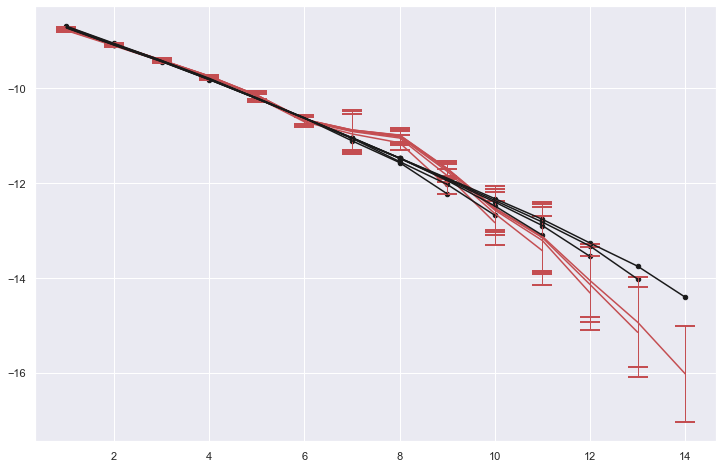

In [10]:
plt.figure(1, figsize = (6.1*2, 4*2))
plt.plot(analyse512_12L[0].j, np.array([analyse512_12L[i].wavelet_result_synthetic[0] for i in range (6)]).mean(axis = 0), 'r')
plt.errorbar(analyse512_12L[0].j,\
             np.array([analyse512_12L[i].wavelet_result_synthetic[0] for i in range (6)]).mean(axis = 0),\
             yerr = np.array([analyse512_12L[i].wavelet_result_synthetic[0] for i in range (6)]).std(axis = 0),\
             fmt = 'none', capsize = 10, ecolor = 'r', elinewidth = 1, capthick = 2)

plt.figure(1, figsize = (6.1*2, 4*2))
plt.plot(analyse512_13L[0].j, np.array([analyse512_13L[i].wavelet_result_synthetic[0] for i in range (6)]).mean(axis = 0), 'r')
plt.errorbar(analyse512_13L[0].j,\
             np.array([analyse512_13L[i].wavelet_result_synthetic[0] for i in range (6)]).mean(axis = 0),\
             yerr = np.array([analyse512_13L[i].wavelet_result_synthetic[0] for i in range (6)]).std(axis = 0),\
             fmt = 'none', capsize = 10, ecolor = 'r', elinewidth = 1, capthick = 2)

plt.plot(analyse512_14L[0].j, np.array([analyse512_14L[i].wavelet_result_synthetic[0] for i in range (6)]).mean(axis = 0), 'r')
plt.errorbar(analyse512_14L[0].j,\
             np.array([analyse512_14L[i].wavelet_result_synthetic[0] for i in range (6)]).mean(axis = 0),\
             yerr = np.array([analyse512_14L[i].wavelet_result_synthetic[0] for i in range (6)]).std(axis = 0),\
             fmt = 'none', capsize = 10, ecolor = 'r', elinewidth = 1, capthick = 2)

plt.plot(analyse512_15L[0].j, np.array([analyse512_15L[i].wavelet_result_synthetic[0] for i in range (6)]).mean(axis = 0), 'r')
plt.errorbar(analyse512_15L[0].j,\
             np.array([analyse512_15L[i].wavelet_result_synthetic[0] for i in range (6)]).mean(axis = 0),\
             yerr = np.array([analyse512_15L[i].wavelet_result_synthetic[0] for i in range (6)]).std(axis = 0),\
             fmt = 'none', capsize = 10, ecolor = 'r', elinewidth = 1, capthick = 2)

plt.plot(analyse512_16L[0].j, np.array([analyse512_16L[i].wavelet_result_synthetic[0] for i in range (6)]).mean(axis = 0), 'r')
plt.errorbar(analyse512_16L[0].j,\
             np.array([analyse512_16L[i].wavelet_result_synthetic[0] for i in range (6)]).mean(axis = 0),\
             yerr = np.array([analyse512_16L[i].wavelet_result_synthetic[0] for i in range (6)]).std(axis = 0),\
             fmt = 'none', capsize = 10, ecolor = 'r', elinewidth = 1, capthick = 2)

plt.plot(analyse512_17L[0].j, np.array([analyse512_17L[i].wavelet_result_synthetic[0] for i in range (6)]).mean(axis = 0), 'r')
plt.errorbar(analyse512_17L[0].j,\
             np.array([analyse512_17L[i].wavelet_result_synthetic[0] for i in range (6)]).mean(axis = 0),\
             yerr = np.array([analyse512_17L[i].wavelet_result_synthetic[0] for i in range (6)]).std(axis = 0),\
             fmt = 'none', capsize = 10, ecolor = 'r', elinewidth = 1, capthick = 2)


plt.plot(analyse512_12L[0].j, analyse512_12L[0].wavelet_result_data[0], c= 'k')
plt.scatter(analyse512_12L[0].j, analyse512_12L[0].wavelet_result_data[0], c = 'k',s=20)

plt.plot(analyse512_13L[0].j, analyse512_13L[0].wavelet_result_data[0], c= 'k')
plt.scatter(analyse512_13L[0].j, analyse512_13L[0].wavelet_result_data[0], c = 'k',s=20)

plt.plot(analyse512_14L[0].j, analyse512_14L[0].wavelet_result_data[0], c= 'k')
plt.scatter(analyse512_14L[0].j, analyse512_14L[0].wavelet_result_data[0], c = 'k',s=20)

plt.plot(analyse512_15L[0].j, analyse512_15L[0].wavelet_result_data[0], c= 'k')
plt.scatter(analyse512_15L[0].j, analyse512_15L[0].wavelet_result_data[0], c = 'k',s=20)

plt.plot(analyse512_16L[0].j, analyse512_16L[0].wavelet_result_data[0], c= 'k')
plt.scatter(analyse512_16L[0].j, analyse512_16L[0].wavelet_result_data[0], c = 'k',s=20)

plt.plot(analyse512_17L[0].j, analyse512_17L[0].wavelet_result_data[0], c= 'k')
plt.scatter(analyse512_17L[0].j, analyse512_17L[0].wavelet_result_data[0], c = 'k',s=20)

plt.show()

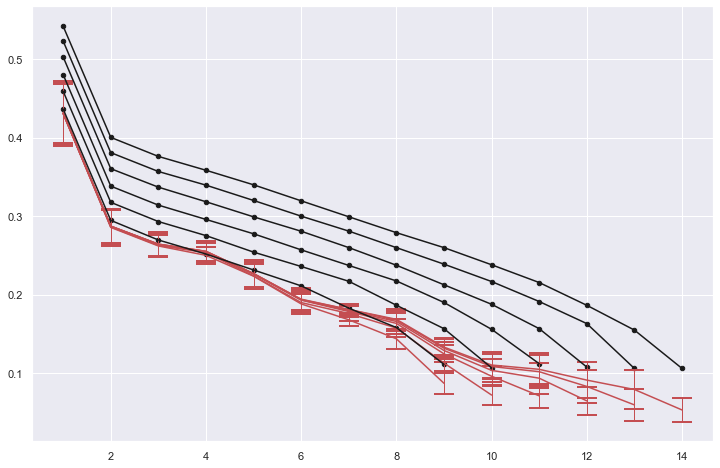

In [11]:
plt.figure(1, figsize = (6.1*2, 4*2))
plt.plot(analyse512_12L[0].j, np.array([analyse512_12L[i].cumul_result2_synthetic[0] for i in range (6)]).mean(axis = 0), 'r')
plt.errorbar(analyse512_12L[0].j,\
             np.array([analyse512_12L[i].cumul_result2_synthetic[0] for i in range (6)]).mean(axis = 0),\
             yerr = np.array([analyse512_12L[i].cumul_result2_synthetic[0] for i in range (6)]).std(axis = 0),\
             fmt = 'none', capsize = 10, ecolor = 'r', elinewidth = 1, capthick = 2)

plt.figure(1, figsize = (6.1*2, 4*2))
plt.plot(analyse512_13L[0].j, np.array([analyse512_13L[i].cumul_result2_synthetic[0] for i in range (6)]).mean(axis = 0), 'r')
plt.errorbar(analyse512_13L[0].j,\
             np.array([analyse512_13L[i].cumul_result2_synthetic[0] for i in range (6)]).mean(axis = 0),\
             yerr = np.array([analyse512_13L[i].cumul_result2_synthetic[0] for i in range (6)]).std(axis = 0),\
             fmt = 'none', capsize = 10, ecolor = 'r', elinewidth = 1, capthick = 2)

plt.plot(analyse512_14L[0].j, np.array([analyse512_14L[i].cumul_result2_synthetic[0] for i in range (6)]).mean(axis = 0), 'r')
plt.errorbar(analyse512_14L[0].j,\
             np.array([analyse512_14L[i].cumul_result2_synthetic[0] for i in range (6)]).mean(axis = 0),\
             yerr = np.array([analyse512_14L[i].cumul_result2_synthetic[0] for i in range (6)]).std(axis = 0),\
             fmt = 'none', capsize = 10, ecolor = 'r', elinewidth = 1, capthick = 2)

plt.plot(analyse512_15L[0].j, np.array([analyse512_15L[i].cumul_result2_synthetic[0] for i in range (6)]).mean(axis = 0), 'r')
plt.errorbar(analyse512_15L[0].j,\
             np.array([analyse512_15L[i].cumul_result2_synthetic[0] for i in range (6)]).mean(axis = 0),\
             yerr = np.array([analyse512_15L[i].cumul_result2_synthetic[0] for i in range (6)]).std(axis = 0),\
             fmt = 'none', capsize = 10, ecolor = 'r', elinewidth = 1, capthick = 2)

plt.plot(analyse512_16L[0].j, np.array([analyse512_16L[i].cumul_result2_synthetic[0] for i in range (6)]).mean(axis = 0), 'r')
plt.errorbar(analyse512_16L[0].j,\
             np.array([analyse512_16L[i].cumul_result2_synthetic[0] for i in range (6)]).mean(axis = 0),\
             yerr = np.array([analyse512_16L[i].cumul_result2_synthetic[0] for i in range (6)]).std(axis = 0),\
             fmt = 'none', capsize = 10, ecolor = 'r', elinewidth = 1, capthick = 2)

plt.plot(analyse512_17L[0].j, np.array([analyse512_17L[i].cumul_result2_synthetic[0] for i in range (6)]).mean(axis = 0), 'r')
plt.errorbar(analyse512_17L[0].j,\
             np.array([analyse512_17L[i].cumul_result2_synthetic[0] for i in range (6)]).mean(axis = 0),\
             yerr = np.array([analyse512_17L[i].cumul_result2_synthetic[0] for i in range (6)]).std(axis = 0),\
             fmt = 'none', capsize = 10, ecolor = 'r', elinewidth = 1, capthick = 2)


plt.plot(analyse512_12L[0].j, analyse512_12L[0].cumul_result2_data[0], c= 'k')
plt.scatter(analyse512_12L[0].j, analyse512_12L[0].cumul_result2_data[0], c = 'k',s=20)

plt.plot(analyse512_13L[0].j, analyse512_13L[0].cumul_result2_data[0], c= 'k')
plt.scatter(analyse512_13L[0].j, analyse512_13L[0].cumul_result2_data[0], c = 'k',s=20)

plt.plot(analyse512_14L[0].j, analyse512_14L[0].cumul_result2_data[0], c= 'k')
plt.scatter(analyse512_14L[0].j, analyse512_14L[0].cumul_result2_data[0], c = 'k',s=20)

plt.plot(analyse512_15L[0].j, analyse512_15L[0].cumul_result2_data[0], c= 'k')
plt.scatter(analyse512_15L[0].j, analyse512_15L[0].cumul_result2_data[0], c = 'k',s=20)

plt.plot(analyse512_16L[0].j, analyse512_16L[0].cumul_result2_data[0], c= 'k')
plt.scatter(analyse512_16L[0].j, analyse512_16L[0].cumul_result2_data[0], c = 'k',s=20)

plt.plot(analyse512_17L[0].j, analyse512_17L[0].cumul_result2_data[0], c= 'k')
plt.scatter(analyse512_17L[0].j, analyse512_17L[0].cumul_result2_data[0], c = 'k',s=20)

plt.show()

In [12]:
sf_512LN = { 'TS_12' : analyse512_12L[0].wavelet_result_data, 
          'TS_13' : analyse512_13L[0].wavelet_result_data, 
          'TS_14' : analyse512_14L[0].wavelet_result_data,     
          'TS_15' : analyse512_15L[0].wavelet_result_data, 
          'TS_16' : analyse512_16L[0].wavelet_result_data,
             'TS_17' : analyse512_17L[0].wavelet_result_data
         }

for i in range (len(generators512)):
    sf_512LN['TConv512_12_{}'.format(i+1)] = analyse512_12L[i].wavelet_result_synthetic
    sf_512LN['TConv512_13_{}'.format(i+1)] = analyse512_13L[i].wavelet_result_synthetic
    sf_512LN['TConv512_14_{}'.format(i+1)] = analyse512_14L[i].wavelet_result_synthetic
    sf_512LN['TConv512_15_{}'.format(i+1)] = analyse512_15L[i].wavelet_result_synthetic
    sf_512LN['TConv512_16_{}'.format(i+1)] = analyse512_16L[i].wavelet_result_synthetic
    sf_512LN['TConv512_17_{}'.format(i+1)] = analyse512_17L[i].wavelet_result_synthetic

savemat(r'C:\Users\Stage\Desktop\dataFigure\Matlab\dataFigureSFConv512largerNLN.mat', sf_512LN)
np.save(r'C:\Users\Stage\Desktop\dataFigure\Python\dataFigureSFConv512largerNLN', sf_512LN)

In [13]:
C2_512LN = { 'TS_12' : analyse512_12L[0].cumul_result2_data, 
          'TS_13' : analyse512_13L[0].cumul_result2_data, 
          'TS_14' : analyse512_14L[0].cumul_result2_data,     
          'TS_15' : analyse512_15L[0].cumul_result2_data, 
          'TS_16' : analyse512_16L[0].cumul_result2_data,
             'TS_17' : analyse512_17L[0].cumul_result2_data
         }

for i in range (len(generators512)):
    C2_512LN['TConv512_12_{}'.format(i+1)] = analyse512_12L[i].cumul_result2_synthetic
    C2_512LN['TConv512_13_{}'.format(i+1)] = analyse512_13L[i].cumul_result2_synthetic
    C2_512LN['TConv512_14_{}'.format(i+1)] = analyse512_14L[i].cumul_result2_synthetic
    C2_512LN['TConv512_15_{}'.format(i+1)] = analyse512_15L[i].cumul_result2_synthetic
    C2_512LN['TConv512_16_{}'.format(i+1)] = analyse512_16L[i].cumul_result2_synthetic
    C2_512LN['TConv512_17_{}'.format(i+1)] = analyse512_17L[i].cumul_result2_synthetic

savemat(r'C:\Users\Stage\Desktop\dataFigure\Matlab\dataFigureC2Conv512largerNLN.mat', C2_512LN)
np.save(r'C:\Users\Stage\Desktop\dataFigure\Python\dataFigureC2Conv512largerNLN', C2_512LN)

In [14]:
sf_mean512LN= { 'TS_12' : analyse512_12L[0].wavelet_result_data, 
                  'T512_12' : np.array([analyse512_12L[i].wavelet_result_synthetic[0] for i in range (6)]).mean(axis = 0),
                  'T512_12_std' :np.array([analyse512_12L[i].wavelet_result_synthetic[0] for i in range (6)]).std(axis = 0),
              
                  'TS_13' : analyse512_13L[0].wavelet_result_data, 
                  'T512_13' : np.array([analyse512_13L[i].wavelet_result_synthetic[0] for i in range (6)]).mean(axis = 0),
                  'T512_13_std' :np.array([analyse512_13L[i].wavelet_result_synthetic[0] for i in range (6)]).std(axis = 0),
             
                  'TS_14' : analyse512_14L[0].wavelet_result_data, 
                  'T512_14' : np.array([analyse512_14L[i].wavelet_result_synthetic[0] for i in range (6)]).mean(axis = 0),
                  'T512_14_std' :np.array([analyse512_14L[i].wavelet_result_synthetic[0] for i in range (6)]).std(axis = 0),
                 
                  'TS_15' : analyse512_15L[0].wavelet_result_data, 
                  'T512_15' : np.array([analyse512_15L[i].wavelet_result_synthetic[0] for i in range (6)]).mean(axis = 0),
                  'T512_15_std' :np.array([analyse512_15L[i].wavelet_result_synthetic[0] for i in range (6)]).std(axis = 0),
                 
                  'TS_16' : analyse512_16L[0].wavelet_result_data, 
                  'T512_16' : np.array([analyse512_16L[i].wavelet_result_synthetic[0] for i in range (6)]).mean(axis = 0),
                  'T512_16_std' :np.array([analyse512_16L[i].wavelet_result_synthetic[0] for i in range (6)]).std(axis = 0),
                 
                 'TS_17' : analyse512_17L[0].wavelet_result_data, 
                 'T512_17' : np.array([analyse512_17L[i].wavelet_result_synthetic[0] for i in range (6)]).mean(axis = 0),
                 'T512_17_std' :np.array([analyse512_17L[i].wavelet_result_synthetic[0] for i in range (6)]).std(axis = 0)  
             }

savemat(r'C:\Users\Stage\Desktop\dataFigure\Matlab\dataFigureSFConv512largerNLNmean.mat', sf_mean512LN)
np.save(r'C:\Users\Stage\Desktop\dataFigure\Python\dataFigureSFConv512largerNLNmean', sf_mean512LN)

In [15]:
C2_mean512LN = { 'TS_12' : analyse512_12L[0].cumul_result2_data, 
                  'T512_12' : np.array([analyse512_12L[i].cumul_result2_synthetic[0] for i in range (6)]).mean(axis = 0),
                  'T512_12_std' :np.array([analyse512_12L[i].cumul_result2_synthetic[0] for i in range (6)]).std(axis = 0),
              
                  'TS_13' : analyse512_13L[0].cumul_result2_data, 
                  'T512_13' : np.array([analyse512_13L[i].cumul_result2_synthetic[0] for i in range (6)]).mean(axis = 0),
                  'T512_13_std' :np.array([analyse512_13L[i].cumul_result2_synthetic[0] for i in range (6)]).std(axis = 0),
             
                  'TS_14' : analyse512_14L[0].cumul_result2_data, 
                  'T512_14' : np.array([analyse512_14L[i].cumul_result2_synthetic[0] for i in range (6)]).mean(axis = 0),
                  'T512_14_std' :np.array([analyse512_14L[i].cumul_result2_synthetic[0] for i in range (6)]).std(axis = 0),
                 
                 'TS_15' : analyse512_15L[0].cumul_result2_data, 
                 'T512_15' : np.array([analyse512_15L[i].cumul_result2_synthetic[0] for i in range (6)]).mean(axis = 0),
                 'T512_15_std' :np.array([analyse512_15L[i].cumul_result2_synthetic[0] for i in range (6)]).std(axis = 0),
                 
                 'TS_16' : analyse512_16L[0].cumul_result2_data, 
                 'T512_16' : np.array([analyse512_16L[i].cumul_result2_synthetic[0] for i in range (6)]).mean(axis = 0),
                 'T512_16_std' :np.array([analyse512_16L[i].cumul_result2_synthetic[0] for i in range (6)]).std(axis = 0),
                 
                 'TS_17' : analyse512_17L[0].cumul_result2_data, 
                 'T512_17' : np.array([analyse512_17L[i].cumul_result2_synthetic[0] for i in range (6)]).mean(axis = 0),
                 'T512_17_std' :np.array([analyse512_17L[i].cumul_result2_synthetic[0] for i in range (6)]).std(axis = 0),
             
               
             }

savemat(r'C:\Users\Stage\Desktop\dataFigure\Matlab\dataFigureC2Conv512largerNLNmean.mat', C2_mean512LN)
np.save(r'C:\Users\Stage\Desktop\dataFigure\Python\dataFigureC2Conv512largerNLNmean', C2_mean512LN)

#### MRW Conv32

##### MRW Conv32 Largr N L12

In [7]:
analyse32_12 = []
analyse32_13 = []
analyse32_14 = []
analyse32_15 = []
analyse32_16 = []
analyse32_17 = []

for i in range (len(generators32)):
    
    noise = torch.normal(mean = 0, std = 0.3, size =(1000, 2**12))
    synthetic_data_12 = generators32[i](noise)
    analysis12 = Analysis_sf(true_data_12, synthetic_data_12, r'C:\Users\Stage\Desktop\mrw_0.8_0.03')
    analyse32_12.append(analysis12)
    
    noise = torch.normal(mean = 0, std = 0.3, size =(1000, 2**13))
    synthetic_data_13 = generators32[i](noise)
    analysis13 = Analysis_sf(true_data_13, synthetic_data_13, r'C:\Users\Stage\Desktop\mrw_0.8_0.03')
    analyse32_13.append(analysis13)

    noise = torch.normal(mean = 0, std = 0.3, size =(1000, 2**14))
    synthetic_data_14 = generators32[i](noise)
    analysis14 = Analysis_sf(true_data_14, synthetic_data_14, r'C:\Users\Stage\Desktop\mrw_0.8_0.03')
    analyse32_14.append(analysis14)
    
    noise = torch.normal(mean = 0, std = 0.3, size =(1000, 2**15))
    synthetic_data_15 = generators32[i](noise)
    analysis15 = Analysis_sf(true_data_15, synthetic_data_15, r'C:\Users\Stage\Desktop\mrw_0.8_0.03')
    analyse32_15.append(analysis15)

    noise = torch.normal(mean = 0, std = 0.3, size =(1000, 2**16))
    synthetic_data_16 = generators32[i](noise)
    analysis16 = Analysis_sf(true_data_16, synthetic_data_16, r'C:\Users\Stage\Desktop\mrw_0.8_0.03')
    analyse32_16.append(analysis16)
    
    noise = torch.normal(mean = 0, std = 0.3, size =(1000, 2**17))
    synthetic_data_17 = generators32[i](noise)
    analysis17 = Analysis_sf(true_data_17, synthetic_data_17, r'C:\Users\Stage\Desktop\mrw_0.8_0.03')
    analyse32_17.append(analysis17)

C:\Users\Stage\anaconda3\lib\site-packages\torch\nn\modules\conv.py:298: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\Convolution.cpp:744.)
  return F.conv1d(input, weight, bias, self.stride,


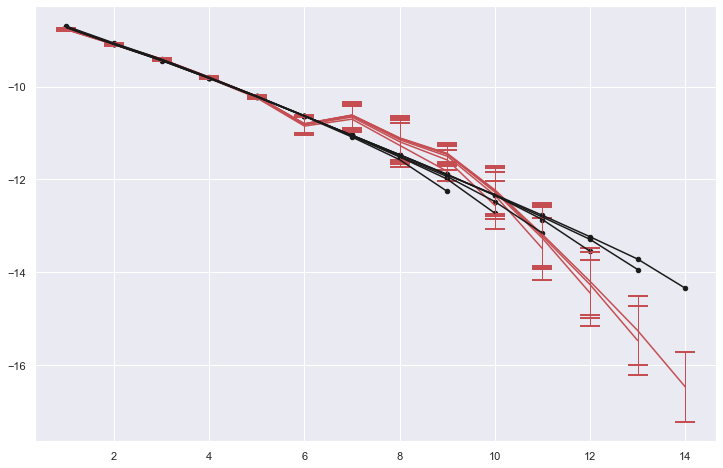

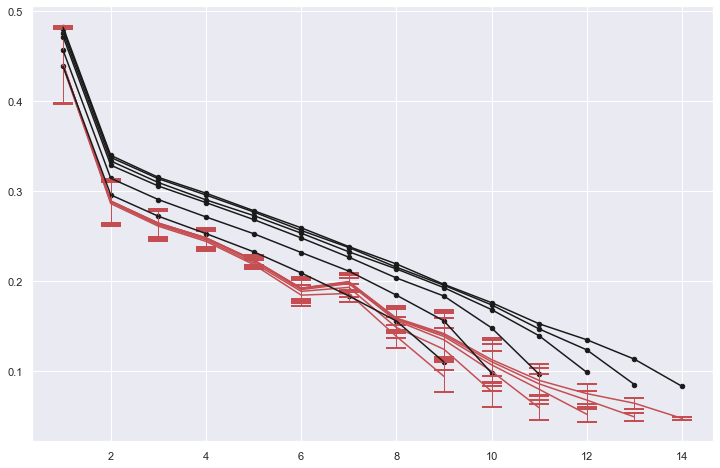

In [10]:
plot_save(generators32, analyse32_12, analyse32_13, analyse32_14, analyse32_15, analyse32_16, analyse32_17, '32', 'Conv32largerNL12')

##### MRW Conv32 Largr N LN

In [7]:
analyse32_12L = []
analyse32_13L = []
analyse32_14L = []
analyse32_15L = []
analyse32_16L = []
analyse32_17L = []

for i in range (len(generators32)):
    
    noise = torch.normal(mean = 0, std = 0.3, size =(1000, 2**12))
    synthetic_data_12 = generators32[i](noise)
    analysis12 = Analysis_sf(true_data_12L, synthetic_data_12, r'C:\Users\Stage\Desktop\mrw_0.8_0.03')
    analyse32_12L.append(analysis12)
    
    noise = torch.normal(mean = 0, std = 0.3, size =(1000, 2**13))
    synthetic_data_13 = generators32[i](noise)
    analysis13 = Analysis_sf(true_data_13L, synthetic_data_13, r'C:\Users\Stage\Desktop\mrw_0.8_0.03')
    analyse32_13L.append(analysis13)

    noise = torch.normal(mean = 0, std = 0.3, size =(1000, 2**14))
    synthetic_data_14 = generators32[i](noise)
    analysis14 = Analysis_sf(true_data_14L, synthetic_data_14, r'C:\Users\Stage\Desktop\mrw_0.8_0.03')
    analyse32_14L.append(analysis14)
    
    noise = torch.normal(mean = 0, std = 0.3, size =(1000, 2**15))
    synthetic_data_15 = generators32[i](noise)
    analysis15 = Analysis_sf(true_data_15L, synthetic_data_15, r'C:\Users\Stage\Desktop\mrw_0.8_0.03')
    analyse32_15L.append(analysis15)

    noise = torch.normal(mean = 0, std = 0.3, size =(1000, 2**16))
    synthetic_data_16 = generators32[i](noise)
    analysis16 = Analysis_sf(true_data_16L, synthetic_data_16, r'C:\Users\Stage\Desktop\mrw_0.8_0.03')
    analyse32_16L.append(analysis16)
    
    noise = torch.normal(mean = 0, std = 0.3, size =(1000, 2**17))
    synthetic_data_17 = generators32[i](noise)
    analysis17 = Analysis_sf(true_data_17L, synthetic_data_17, r'C:\Users\Stage\Desktop\mrw_0.8_0.03')
    analyse32_17L.append(analysis17)

C:\Users\Stage\anaconda3\lib\site-packages\torch\nn\modules\conv.py:298: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\Convolution.cpp:744.)
  return F.conv1d(input, weight, bias, self.stride,


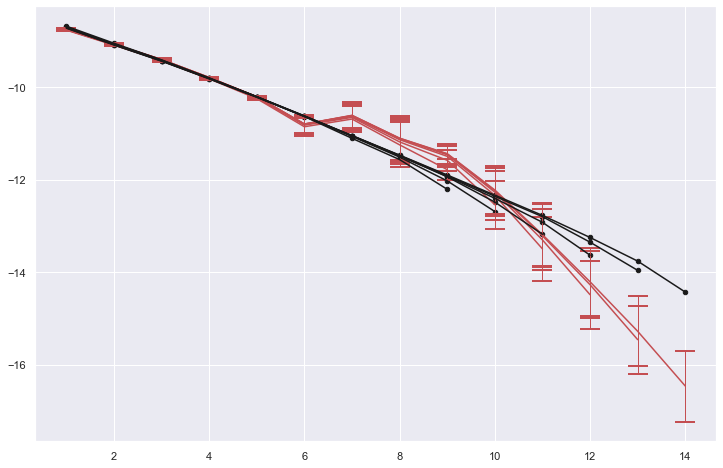

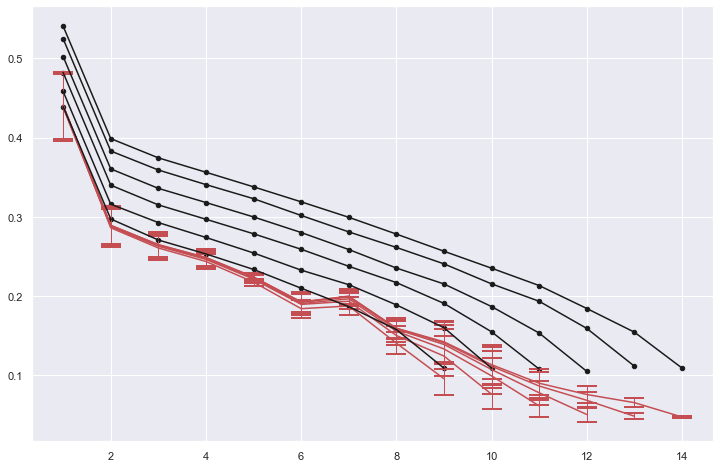

In [9]:
plot_save(generators32, analyse32_12L, analyse32_13L, analyse32_14L, analyse32_15L, analyse32_16L, analyse32_17L, '32', 'Conv32largerNLN')